# This notebook implements spectral domain analysis of HRV

## Implemented by Anuththara Rupasinghe

### Two different methods for deriving the Multi-taper Spectral Estimates from the Inter-Heart-Beat-Interval Time series:
- #### Denoised Multi-taper Spectral Estimates
- #### Direct (Classical) Multi-taper Spectral Estimates

### Two different methods for deriving the Confidence Bounds of the Multi-taper Spectral Estimates:
- #### Confidence Bounds through Bootstrapping (An implementation of Kim et al., 2018: A Multitaper Frequency-Domain Bootstrap Method)
- #### Confidence Bounds using the Chi-squared approximation (Percival & Walden, 1993: Spectral analysis for Physical Applications, Pages 255 & 343)

## Import required packages

In [1]:
# Package imports

import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from scipy import stats
from scipy.signal import windows, freqz
from scipy.stats.distributions import chi2

%matplotlib inline

## Define the necessary supporting functions

### Function 1: Loading data to the workspace and perform pre-processing

In [2]:
# Function 1: Loading data to the workspace and perform pre-processing: Linearly interpolate the NN time series and zero center

# Inputs:
    # filename_data:             The path to the NN files
    # fs:                        Sampling frequency
    
# Output:
    # NN_intervals_interpolated: The linearly interpolated and zero centered NN time series

def data_pre_processing(filename_data, fs):
    
    NN_intervals = np.loadtxt(filename_data)
    # remove the time intervals that are not valid
    NN_intervals = NN_intervals[~np.isnan(NN_intervals)]

    spike_times = np.cumsum(NN_intervals)/1000

    dt = 1/fs 
    T = np.floor(spike_times.max(0)) # Observation duration in seconds
    t = np.arange(1.0, T, dt) # Consider a linearly spaced time axis

    # Derive the linearly interpolated NN time series
    NN_intervals_interpolated = np.interp(t,spike_times,NN_intervals)
    K = NN_intervals_interpolated.shape[0]

    plt.figure(figsize=(12,5))
    plt.subplot(2, 1, 1)
    plt.plot(spike_times, NN_intervals)
    plt.autoscale(enable=True, tight=True)
    plt.title('Original time series')
    plt.xlabel("time (seconds)")
    plt.ylabel("Inter heart beat interval (ms)")
    plt.subplot(2, 1, 2)
    plt.plot(t[0:K], NN_intervals_interpolated)
    plt.autoscale(enable=True, tight=True)
    plt.title('With Linear Interpolation')
    plt.xlabel("time (seconds)")
    plt.ylabel("Inter heart beat interval (ms)")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
    plt.show()

    # Zero centering the time series prior to multi-tapering
    NN_intervals_interpolated = NN_intervals_interpolated - np.mean(NN_intervals_interpolated)
    NN_intervals_interpolated = NN_intervals_interpolated.reshape((K,1))
    return NN_intervals_interpolated

### Function 2: Estimate Denoised Multi-taper Spectral Estimates

In [3]:
# Function 2: This funcition performs Expectation Maximization to estimate the denoised Eigen coefficients and denoised Multitaper spectral estimates

# Inputs:
    # NN_intervals_interpolated:     The interpolated inter heart beat interval time series
    # N:                             Total number of frequency bins
    # NW:                            Time half bandwidth of multitapering
    # no_of_tapers:                  Number of tapers considered for multitapering
    
# Outputs:
    # Denoised_MT_est:               Denoised multitaper estimate of the Power Spectral Density
    # Denoised_MT_est_w_est_tapers:  The real and imaginery components of the Denoised Eigen-coefficients for each taper

def Denoised_MT_Spectral_Estimation(NN_intervals_interpolated, N, NW, no_of_tapers):
    
    # Initializing the parameters
    iter_EM = 50 # Maximum EM iterations
    Q_initial_factor = 10**(5) # Initialization of Q
    sigma_observation = 1*10**(4) # Initialization of Observation noise variance
    Sequences = scipy.signal.windows.dpss(K, NW, Kmax=no_of_tapers) # Generate the data tapers used for multitapering

    # constructing the inverse FFT matrix (A)
    A=np.zeros((K,2*N))
    for k in range(0,K):
        for n in range(0,N):
            A[k,2*n] = np.cos((k+1)*np.pi*(n)/N)
            A[k,2*n+1] = -np.sin((k+1)*np.pi*(n)/N)
    A= A/N
    A = np.delete(A, 1, 1)
    
    Denoised_MT_est_tapers = np.zeros((N, no_of_tapers)) # Stores the Denoised Eigen spectra for each taper
    Denoised_w_est_tapers = np.zeros(((2*N - 1),no_of_tapers)) # Stores the Denoised Eigen coefficients for each taper

    # Derive the denoised Eigen coefficients for each taper using Expectation Maximization
    for taper in range(0,no_of_tapers):
        print("Estimating denoised Eigen-coefficients for taper", taper+1)
        Q = Q_initial_factor*np.eye((2*N - 1)) # Initialize the Q matrix
        taper_sequence = Sequences[taper,:]
        taper_sequence = taper_sequence.reshape((K,1))    
        tapered_NN_intervals = taper_sequence*NN_intervals_interpolated # Obtain the tapered time series
        tapered_NN_intervals = tapered_NN_intervals.reshape((K,1))
        w_est = np.zeros((2*N-1, 1))
        P_est = np.zeros((2*N-1, 2*N-1))

        # Expectation Maximization
        for r in range(0,iter_EM):
            # Expectation step (E - step)
            w_est = np.linalg.pinv(A.T@A + np.linalg.pinv(Q)*sigma_observation)@(A.T@tapered_NN_intervals) # Update the expected value of the denoised Eigen coefficients
            P_est =  ((np.linalg.pinv(A.T@A/sigma_observation + np.linalg.pinv(Q)))) # Update the covariance of the denoised Eigen coefficients
            # Maximization (M - step)
            Q = np.diag(np.diag(P_est + w_est@w_est.T)) # Update the Q matrix
            sigma_observation = (tapered_NN_intervals.T@tapered_NN_intervals - 2*tapered_NN_intervals.T@A@w_est + np.trace((A.T)@(A)@(P_est + w_est@w_est.T)))/K # Update the observation noise variance
           # print(sigma_observation)                               

        # Store estimated denoised Eigen coefficients for all tapers
        Denoised_w_est_tapers[:,taper] = w_est[:,0]

        # Derive and store the denoised Eigen spectra
        final_eigen_spectra = w_est@w_est.T
        Denoised_MT_est_tapers[0,taper] = final_eigen_spectra[0,0]
        for n in range(1,N):
            Denoised_MT_est_tapers[n,taper] =  final_eigen_spectra[2*n-1,2*n-1] + final_eigen_spectra[2*n,2*n]

    # The final multi-taper estimates are the average spectral estimates across all tapers
    Denoised_MT_est = np.mean(np.absolute(Denoised_MT_est_tapers), axis=1, keepdims = True)
    
    return Denoised_MT_est, Denoised_w_est_tapers                           

### Function 3: Estimate Direct (Classical) Multi-taper Spectral Estimates

In [4]:
# Function 3: This function produces the classical multitaper estimate of the Power Spectral Density 

# Inputs:
    # NN_intervals_interpolated: The interpolated inter heart beat interval time series
    # NW:                        Time half bandwidth of multitapering
    # no_of_tapers:              Number of tapers considered for multitapering
    # N:                         Total number of frequency bins
    
# Outputs:
    # Direct_MT_est:             The classical multitaper estimate of the Power Spectral Density
    # Direct_w_est_tapers:       The real and imaginery components of the Eigen-coefficients for each taper
    
def Direct_MT_Spectral_Estimation(NN_intervals_interpolated, N, NW, no_of_tapers):
    
    # Initializing variables
    K = NN_intervals_interpolated.shape[0] # Observation duration in samples
    Fourier_est = np.zeros((2*N, no_of_tapers),dtype=complex) # Eigen Spectra
    Direct_MT_est_tapers = np.zeros((2*N,no_of_tapers)) # Classical Multi-taper spectral estimate
    Direct_w_est_tapers = np.zeros((2*N-1,no_of_tapers)) # The real and imaginery components of the Eigen-coefficients for each taper
    dpss_seq = scipy.signal.windows.dpss(K, NW, Kmax=no_of_tapers) # Generate the data tapers used for multitapering

    # Computing the Eigen-coefficients and the Eigenspectra for each taper
    for taper in range(0,no_of_tapers):
        temp = NN_intervals_interpolated.T*dpss_seq[taper,:]
        Fourier_est[:, taper] = ((np.fft.fft(temp, n = 2*N)).T).reshape((2*N,)) # Eigen-coefficients of the tapered process
        Direct_w_est_tapers[0,taper] = np.absolute(Fourier_est[0,taper]) # dc component
        Direct_w_est_tapers[1:2*N-1:2,taper] = np.real(Fourier_est[1:N,taper]) # real components
        Direct_w_est_tapers[2:2*N-1:2,taper] = np.imag(Fourier_est[1:N,taper]) # imaginary components
        Direct_MT_est_tapers[:,taper] = (np.absolute(Fourier_est[:, taper]))**2 # Eigenspectral estimates

    # The final multi-taper estimates are the average spectral estimates across all tapers
    Direct_MT_est = np.mean(Direct_MT_est_tapers[0:N,:], axis=1, keepdims = True)
    
    return Direct_MT_est, Direct_w_est_tapers                           

### Function 4: Derive Confidence Bounds through Bootstrapping

In [5]:
# Function 4: Perform bootstrapping to derive confidence bounds (An implementation of Kim et al.,2018: A Multitaper Frequency-Domain Bootstrap Method)

# Inputs:
    # MT_est: `              Multitaper estimate of the Power Spectral Density
    # w_est_tapers:          The real and imaginery components of the Eigen coefficients of each taper
    # CI:                    The desired confidence bounds
    # bootstrapping_repeats: The number of bootstrap repeats
    # fs:                    Sampling frequency
    # K:                     Observation duration in samples
    
# Outputs:
    # Lower_confidence_PSD:  The lower confidence bound of the multi-taper spectral estimates
    # Upper_confidence_PSD:  The upper confidence bound of the multi-taper spectral estimates

def Confidence_Intervals_Bootstrapping(MT_est, w_est_tapers, CI, bootstrapping_repeats, fs, K):
    
    N = MT_est.shape[0] # Number of frequency bins
    scaling_fac = (1/fs)*(K / N) # The scaling factor of the final estimates

    no_of_tapers = w_est_tapers.shape[1] # The number of tapers used for multi-tapering

    Denoised_MT_est_bootstrap = np.zeros((N,bootstrapping_repeats)) # Store bootstrapped MT estimates

    #  Step 2 (Kim et al., 2018): Scale the Eigen coefficients by the power of the MT estimates
    scaled_w_hat = w_est_tapers
    scaled_w_hat[0,:] = scaled_w_hat[0,:]/np.sqrt(MT_est[0]/2)
    for n in range(0,N-1):
        S_fac = np.sqrt(MT_est[n+1]/2)
        scaled_w_hat[2*n+1,:] = scaled_w_hat[2*n+1,:] / S_fac
        scaled_w_hat[2*n+2,:] = scaled_w_hat[2*n+2,:] / S_fac    

    # Step 3 (Kim et al., 2018): Standardize the concatanated Eigencoefficients to have zero mean and unit variance
    for taper in range(0,no_of_tapers):
        temp = scaled_w_hat[:,taper]
        scaled_w_hat[:,taper] = [temp - np.mean(temp)]/np.sqrt(np.mean((temp - np.mean(temp))**2))

    # Perform the bootstrapping
    for i in range(0,bootstrapping_repeats):    
        Denoised_MT_est_bootstrap_taper = np.zeros((N,no_of_tapers)) # Bootstrapped MT estimate for each taper
        scaled_w_hat_bootstrap = np.zeros((2*N-1,no_of_tapers)) #. Bootstrapped Eigen coefficients        
        for n in range(0,scaled_w_hat.shape[0]):
            temp = scaled_w_hat[n,:]
            bootstrap_order = np.random.randint(no_of_tapers, size=no_of_tapers) # Step 4 (Kim et al., 2018): bootstrapping with replacement
            scaled_w_hat_bootstrap[n,:] = temp[bootstrap_order]
            # Step 5 (Kim et al., 2018): Re-scale the bootstrapped eigen coefficients
            if n == 0:
                scaled_w_hat_bootstrap[n,:] = scaled_w_hat_bootstrap[n,:]*np.sqrt(MT_est[0]/2)
            else:
                scaled_w_hat_bootstrap[n,:] = scaled_w_hat_bootstrap[n,:]*np.sqrt(MT_est[(np.ceil(n/2)).astype(int)]/2)                
        # Step 6 (Kim et al., 2018): Derive the bootstrapped Eigen spectra for each taper
        for taper in range(0,no_of_tapers):
            temp = scaled_w_hat_bootstrap[:,taper]
            temp = temp.reshape((temp.shape[0],1))
            final_eigen_spectra_bootstrap = temp@temp.T
            Denoised_MT_est_bootstrap_taper[0,taper] = final_eigen_spectra_bootstrap[0,0]
            for n in range(0,N-1):
                Denoised_MT_est_bootstrap_taper[n+1,taper] =  final_eigen_spectra_bootstrap[2*n+1,2*n+1]+final_eigen_spectra_bootstrap[2*n+2,2*n+2]    
        # Derive the bootstrapped Multitaper Spectral Estimates
        temp = scaling_fac*np.mean(np.absolute(Denoised_MT_est_bootstrap_taper), axis=1, keepdims = True)
        Denoised_MT_est_bootstrap[:,i] = temp.reshape((temp.shape[0],))

    # Specify the lower and upper percentiles based on the desired Confidence Intervals
    lower_percentile = (np.floor(((1-CI)/2)*bootstrapping_repeats)).astype(int)
    upper_percentile = (np.ceil(((1+CI)/2)*bootstrapping_repeats)).astype(int)
    Upper_confidence_PSD = np.zeros((N,1))
    Lower_confidence_PSD = np.zeros((N,1))

    # Derive the confidence bounds using the upper and lower percentiles
    for n in range(0,N):
        temp = np.sort(Denoised_MT_est_bootstrap[n,:])
        Lower_confidence_PSD[n] = temp[lower_percentile]
        Upper_confidence_PSD[n] = temp[upper_percentile]

    return Lower_confidence_PSD.reshape((N,)), Upper_confidence_PSD.reshape((N,))


### Function 5: Derive Confidence Bounds using the Chi-squared approximation

In [6]:
# Function 5: Deriving confidence bounds based on the Chi-squared approximation (Percival & Walden, 1993: Spectral analysis for Physical Applications, Page 255 & 343)

# Inputs:
    # MT_est: `              Multitaper estimate of the Power Spectral Density
    # CI:                    The desired confidence bounds
    # no_of_tapers:          Number of tapers used for multitapering
    
# Outputs:
    # Lower_confidence_PSD:  The lower confidence bound of the multi-taper spectral estimates
    # Upper_confidence_PSD:  The upper confidence bound of the multi-taper spectral estimates


def Confidence_Intervals_Chi_squared(MT_est, CI, no_of_tapers):
    
    # The Degrees of freedom of the Chi-squared distribution equals to twice the number of tapers used in multi-tapering
    Degree_of_freedom = 2*no_of_tapers
    
    Lower_confidence_PSD = (Degree_of_freedom / chi2.ppf((1+CI)/2, df=Degree_of_freedom)) * abs(MT_est);
    Upper_confidence_PSD = (Degree_of_freedom / chi2.ppf((1-CI)/2, df=Degree_of_freedom)) * abs(MT_est);

    return Lower_confidence_PSD.reshape((N,)), Upper_confidence_PSD.reshape((N,))

### Function 6: Plot the final PSD estimates with the confidence levels

In [7]:
# Function 6:  Plot the final PSD estimates with the confidence levels

# Inputs:
    # MT_PSD_est: `             Multitaper estimate of the Power Spectral Density
    # Lower_confidence_PSD:     The lower confidence bound of the multi-taper spectral estimates
    # Upper_confidence_PSD:     The upper confidence bound of the multi-taper spectral estimates
    # fs:                       Sampling frequency
    
def plot_estimates(MT_PSD_est, Lower_confidence_PSD, Upper_confidence_PSD, fs):
    
    N = MT_PSD_est.shape[0]
    freq_vector = np.arange(0.0, 0.5*fs, 0.5*fs/N)
    y_axis_upper_bound = 20*10**4

    fig, ax = plt.subplots(figsize=(15,3))
    
    freq_1 = np.max(freq_vector[freq_vector<= 0.04])
    ax.plot([freq_1,freq_1],[0,y_axis_upper_bound], 'b--')
    freq_2 = np.max(freq_vector[freq_vector<= 0.15])
    ax.plot([freq_2,freq_2],[0,y_axis_upper_bound], 'b--')
    freq_3 = np.max(freq_vector[freq_vector<= 0.40])
    ax.plot([freq_3,freq_3],[0,y_axis_upper_bound], 'b--')

    ax.plot(freq_vector, MT_PSD_est, color="black")
    ax.fill_between(freq_vector, Lower_confidence_PSD, Upper_confidence_PSD, color='k', alpha=.4)
    plt.xlabel("frequency ($Hz$)")
    plt.ylabel("Power ($ms^2/Hz$)")
    
    plt.xlim([np.min(freq_vector), np.max(freq_vector)])
    plt.ylim([0, y_axis_upper_bound])

## Peform the required tasks using the pre-defined functions

### Main task 1. Load data into the workspace, specify the parameters and perform data pre-processing

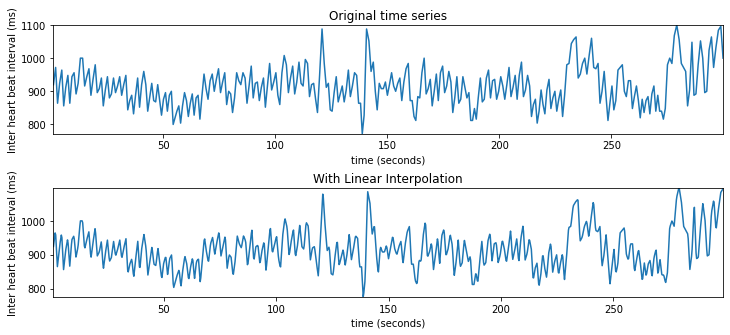

Multi-taper spectral resolution:  0.006711409395973154


In [8]:
# Main task 1. Load data into the workspace and specify the parameters - pre processing

# Specify the path the nn file
filename_data = 'E:\Data from Jackie\Data_forAnuththara\HC212_nn_files\HC212_2014-01-08_awake_cycle1_epoch6_223000_nn.txt';

# Specify the desired sampling frequency of the time series in Hz
fs = 4;

# Extract the interpolated and zero centered NN time series
NN_intervals_interpolated = data_pre_processing(filename_data, fs)
K = NN_intervals_interpolated.shape[0]

# Set the parameters required for Spectral analysis - multi tapering
N = 512        # Number of frequency bins considered in the frequency interval [0,fs/2). This determines the frequency spacing.  
NW = 2             # time half-bandwidth product of Multitapering
no_of_tapers = 3   # the number of tapers considered for Multitapering

# Set the parameters required for Confidence Intervals
CI = 0.95  # Specify the Required Confidence levels
bootstrapping_repeats = 5000 # Specify the number of bootstrap samples

scaling_fac = (1/fs)*(K / N) # Final scaling factor of the PSD estimates

multi_tapering_spectral_resolution = NW*fs/K

print("Multi-taper spectral resolution: ", multi_tapering_spectral_resolution)

### Main task 2. Derive the Denoised Multi-taper Spectral Estimates

Estimating denoised Eigen-coefficients for taper 1
Estimating denoised Eigen-coefficients for taper 2
Estimating denoised Eigen-coefficients for taper 3


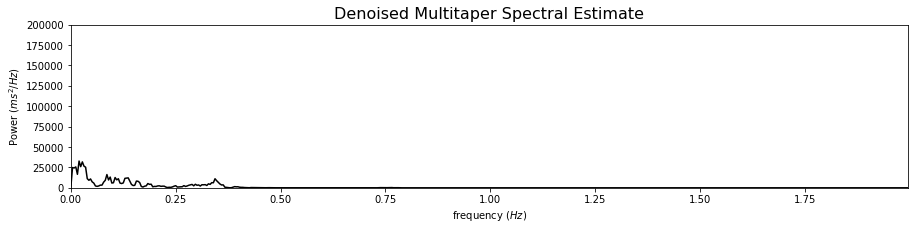

In [9]:
# Main task 2. Derive the Denoised Multi-taper Spectral Estimates

Denoised_MT_est, Denoised_w_est_tapers = Denoised_MT_Spectral_Estimation(NN_intervals_interpolated, N, NW, no_of_tapers)

# Multiply by the required scaling factors to get the final spectral estimates
Denoised_MT_est_final = scaling_fac*Denoised_MT_est;                        

freq_vector = np.arange(0.0, 0.5*fs, 0.5*fs/N)
y_axis_upper_bound = 20*10**4

plt.figure(figsize=(15,3))
plt.plot(freq_vector, Denoised_MT_est_final, color="black")
plt.title('Denoised Multitaper Spectral Estimate',fontdict = {'fontsize' : 16})
plt.xlabel("frequency ($Hz$)")
plt.ylabel("Power ($ms^2/Hz$)")
plt.xlim([np.min(freq_vector), np.max(freq_vector)])
plt.ylim([0, y_axis_upper_bound])
plt.show()


### Main task 3. Confidence bounds based on Bootstrapping for the Denoised Multi-taper Spectral Estimates

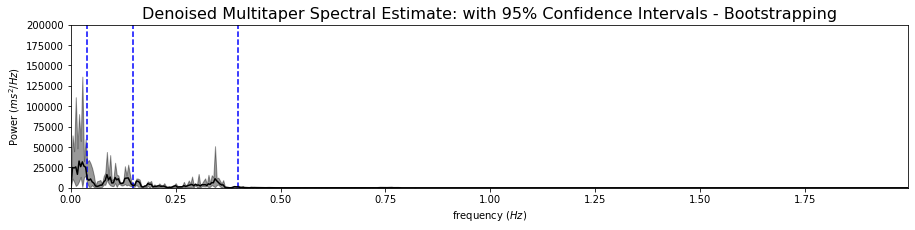

In [10]:
# Main task 3. Derive confidence bounds based on Bootstrapping for the Denoised Multi-taper Spectral Estimates

Denoised_MT_est_Lower_confidence_bootstrap, Denoised_MT_est_Upper_confidence_bootstrap = Confidence_Intervals_Bootstrapping(Denoised_MT_est, Denoised_w_est_tapers, CI, bootstrapping_repeats, fs, K)

plot_estimates(Denoised_MT_est_final, Denoised_MT_est_Lower_confidence_bootstrap, Denoised_MT_est_Upper_confidence_bootstrap, fs)
plt.title('Denoised Multitaper Spectral Estimate: with %d%% Confidence Intervals - Bootstrapping'% (CI*100),fontdict = {'fontsize' : 16}) 
plt.show()
    

### Main task 4. Confidence bounds based on Chi-squared test for the Denoised Multi-taper Spectral Estimates

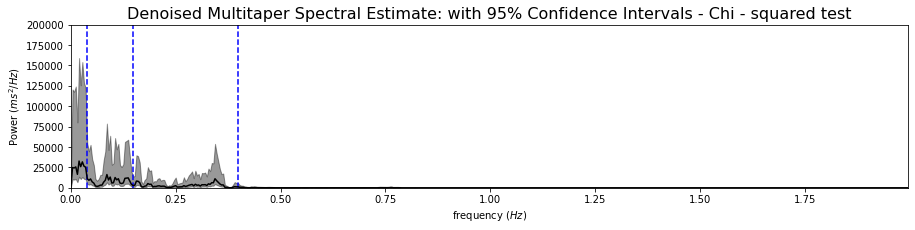

In [11]:
# Main task 4. Derive confidence bounds based on the Chi-squared test for the Denoised Multi-taper Spectral Estimates

Denoised_MT_est_Lower_confidence_Chi_squared, Denoised_MT_est_Upper_confidence_Chi_squared = Confidence_Intervals_Chi_squared(Denoised_MT_est_final, CI, no_of_tapers)

plot_estimates(Denoised_MT_est_final, Denoised_MT_est_Lower_confidence_Chi_squared, Denoised_MT_est_Upper_confidence_Chi_squared, fs)
plt.title('Denoised Multitaper Spectral Estimate: with %d%% Confidence Intervals - Chi - squared test'% (CI*100),fontdict = {'fontsize' : 16})
plt.show()


### Main task 5. Derive the Direct Multi-taper Spectral Estimates

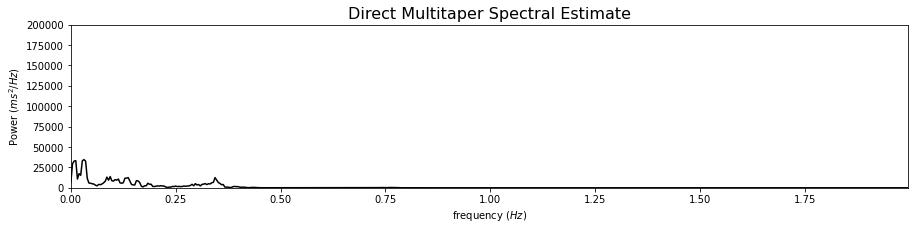

In [12]:
# Main task 5. Derive the Direct Multi-taper Spectral Estimates

Direct_MT_est, Direct_w_est_tapers = Direct_MT_Spectral_Estimation(NN_intervals_interpolated, N, NW, no_of_tapers)
    
# Multiply by the required scaling factors to get the final spectral estimates
Direct_MT_est_final = scaling_fac*Direct_MT_est

plt.figure(figsize=(15,3))
plt.plot(freq_vector, Direct_MT_est_final, color="black")
plt.title('Direct Multitaper Spectral Estimate',fontdict = {'fontsize' : 16})
plt.xlabel("frequency ($Hz$)")
plt.ylabel("Power ($ms^2/Hz$)")
plt.xlim([np.min(freq_vector), np.max(freq_vector)])
plt.ylim([0, y_axis_upper_bound])
plt.show()


### Main task 6. Confidence bounds based on Bootstrapping for the Direct Multi-taper Spectral Estimates

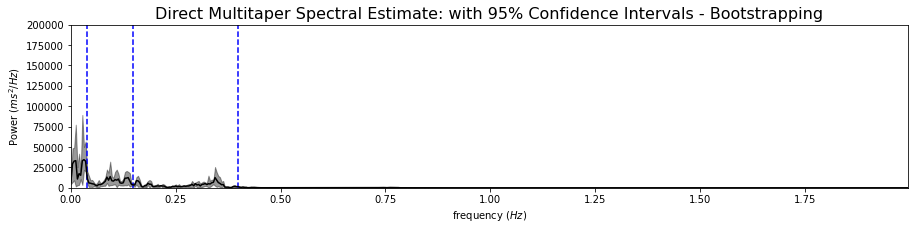

In [13]:
# Main task 6. Derive confidence bounds based on Bootstrapping for the Direct Multi-taper Spectral Estimates

Direct_MT_est_Lower_confidence_bootstrap, Direct_MT_est_Upper_confidence_bootstrap = Confidence_Intervals_Bootstrapping(Direct_MT_est, Direct_w_est_tapers, CI, bootstrapping_repeats, fs, K)

plot_estimates(Direct_MT_est_final, Direct_MT_est_Lower_confidence_bootstrap, Direct_MT_est_Upper_confidence_bootstrap, fs)
plt.title('Direct Multitaper Spectral Estimate: with %d%% Confidence Intervals - Bootstrapping'% (CI*100),fontdict = {'fontsize' : 16})
plt.show()
  

### Main task 7. Confidence bounds based on Chi-squared test for the Direct Multi-taper Spectral Estimates

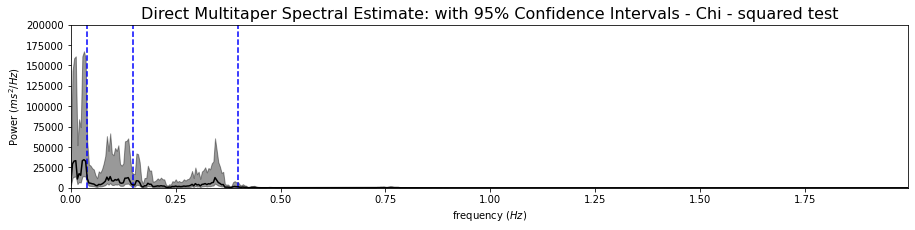

In [14]:
# Main task 7. Derive confidence bounds based on the Chi-squared test for the Direct Multi-taper Spectral Estimates

Direct_MT_est_Lower_confidence_Chi_squared, Direct_MT_est_Upper_confidence_Chi_squared = Confidence_Intervals_Chi_squared(Direct_MT_est_final, CI, no_of_tapers)

plot_estimates(Direct_MT_est_final, Direct_MT_est_Lower_confidence_Chi_squared, Direct_MT_est_Upper_confidence_Chi_squared, fs)
plt.title('Direct Multitaper Spectral Estimate: with %d%% Confidence Intervals - Chi - squared test'% (CI*100),fontdict = {'fontsize' : 16})
plt.show()
